### Major definition

"Administrative", "Administrative Duration", "Informational", "Informational Duration", "Product Related" and "Product Related Duration" represent the number of different types of pages visited by the visitor in that session and total time spent in each of these page categories. The values of these features are derived from the URL information of the pages visited by the user and updated in real time when a user takes an action, e.g. moving from one page to another. The "Bounce Rate", "Exit Rate" and "Page Value" features represent the metrics measured by "Google Analytics" for each page in the e-commerce site. The value of "Bounce Rate" feature for a web page refers to the percentage of visitors who enter the site from that page and then leave ("bounce") without triggering any other requests to the analytics server during that session.

The value of "Exit Rate" feature for a specific web page is calculated as for all pageviews to the page, the percentage that were the last in the session. 

The "Page Value" feature represents the average value for a web page that a user visited before completing an e-commerce transaction.

The "Special Day" feature indicates the closeness of the site visiting time to a specific special day (e.g. Mother’s Day, Valentine's Day) in which the sessions are more likely to be finalized with transaction. The value of this attribute is determined by considering the dynamics of e-commerce such as the duration between the order date and very date. For example, for Valentina’s day, this value takes a nonzero value between February 2 and February 12, zero before and after this date unless it is close to another special day, and its maximum value of 1 on February 8. 

The dataset also includes operating system, browser, region, traffic type, visitor type as returning or new visitor, a Boolean value indicating whether the date of the visit is weekend, and month of the

In [1]:
import numpy as np
import pandas as pd

import os
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from bayes_opt import BayesianOptimization
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# model evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# classifiers
from sklearn.linear_model import LogisticRegression # logistic regression
from sklearn.tree import DecisionTreeClassifier # decision tree
from sklearn.ensemble import RandomForestClassifier # random forest
from sklearn.ensemble import GradientBoostingClassifier# gradient boosting
import lightgbm as lgb
from bayes_opt import BayesianOptimization

import lightgbm as lgb
from sklearn import metrics

from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVC, SVC
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
pd.options.display.precision = 15

import lightgbm as lgb
import time
import datetime

import json
import ast
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, train_test_split
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from numpy.random import normal
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import os
from sklearn.model_selection import StratifiedKFold
from math import exp

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

pd.pandas.set_option('display.max_columns', None)

/Users/hwang/opt/anaconda3/envs/py37/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


### 1. EDA: columnar missing vals, distribution and some plots

In [2]:
def missing_data(data):
    '''
    display of missing information per column
    '''
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

def plot_feature_distribution(df1, df2, label1, label2, features):
    '''
    numerical feature ditribution comparator for binary labelled segments
    '''
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(3,3,figsize=(10,10))

    for feature in features:
        try:
            i += 1
            plt.subplot(3,3,i)
            sns.distplot(df1[feature], hist=False,label=label1)
            sns.distplot(df2[feature], hist=False,label=label2)
            plt.xlabel(feature, fontsize=9)
            locs, labels = plt.xticks()
            plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
            plt.tick_params(axis='y', which='major', labelsize=6)
        except:
            continue
    plt.show();
    
def count_ctgy_spread(df,ctgy_cols):
    '''
    count in each categorical column,
    how many variety they have
    returns the suggested methods to process columns, using config
    '''
    res = {}
    advice = {}
    for col in ctgy_cols:
        val = df[col].value_counts().reset_index().shape[0]
        if val <= 6:
            advice[col] = 'one_hot'
        elif val > 6 and val <= 10:
            advice[col] = 'mid_level'
        else:
            advice[col] = 'encoding'
        
        res[col] = val
    print('column:number of unique records')
    return res,advice

In [3]:
# starting point, read in raw data
df = pd.read_csv('online_shoppers_intention.csv')

# categorical feature coersive conversion
df['SpecialDay'] = df['SpecialDay'].astype('O')
df['OperatingSystems'] = df['OperatingSystems'].astype('O')
df['Browser'] = df['Browser'].astype('O')
df['Region'] = df['Region'].astype('O')
df['TrafficType'] = df['TrafficType'].astype('O')
df['Revenue'] = df['Revenue'].astype(int)

# convenient vars for columns
feature_cols = df.columns.tolist()
feature_cols.remove('Revenue')
feature_obj_cols = df.select_dtypes('O').columns.tolist()
feature_num_cols = [x for x in feature_cols if x not in feature_obj_cols]

#show columnar missing values conditions
missing_data(df)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
Total,14,14,14,14,14,14,14,14,0,0,0,0,0,0,0,0,0,0
Percent,0.113544201135442,0.113544201135442,0.113544201135442,0.113544201135442,0.113544201135442,0.113544201135442,0.113544201135442,0.113544201135442,0,0,0,0,0,0,0,0,0,0
Types,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,object,object,object,object,object,bool,int64


In [4]:
#fillna on the numerical columns, using mean
for col in df.select_dtypes(exclude='O').columns.tolist():
    df[col].fillna(df[col].mean(),inplace=True)

In [5]:
train, test = train_test_split(df, test_size=0.2,random_state = 42)

### Build benchmark model, off the shelf LR

In [6]:
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

def benchmark_model(df,target_col):
    '''
    benchmark model, using simple off shelf models
    we use LR off shelf as benchmark model
    '''
    #fillna on the numerical columns, using mean
    for col in df.select_dtypes(exclude='O').columns.tolist():
        df[col].fillna(df[col].mean(),inplace=True)
    
    #remove target column, keep the features columns
    all_cols = df.columns.tolist()
    all_cols.remove(target_col)
    
    #split dataset immediately avoid data leakage
    train, test = train_test_split(df, test_size=0.2)
    
    #use get dummies on all categoricals
    X_train = pd.get_dummies(train[all_cols])
    y_train = train[target_col]
    
    X_test = pd.get_dummies(test[all_cols])
    y_test = test[target_col]

    
    # Get missing columns in the training test
    missing_cols = set( X_train.columns ) - set( X_test.columns )
    # Add a missing column in test set with default value equal to 0
    for c in missing_cols:
        X_test[c] = 0
    # Ensure the order of column in the test set is in the same order than in train set
    X_test = X_test[X_train.columns]

    ns_probs = [0 for _ in range(len(y_test))]
    # fit a model
    model = LogisticRegression()
    model.fit(X_train, y_train)
    # predict probabilities
    lr_probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]

    # calculate scores
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Logistic: ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    # plot the roc curve for the model
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Random')
    pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()

    return None

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.878


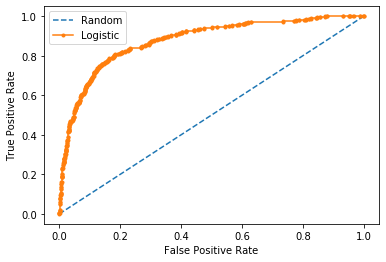

In [7]:
ac = benchmark_model(df,target_col='Revenue')

### Feature engineering

The "Special Day" feature indicates the closeness of the site visiting time to a specific special day (e.g. Mother’s Day, Valentine's Day) in which the sessions are more likely to be finalized with transaction. The value of this attribute is determined by considering the dynamics of e-commerce such as the duration between the order date and very date. For example, for Valentina’s day, this value takes a nonzero value between February 2 and February 12, zero before and after this date unless it is close to another special day, and its maximum value of 1 on February 8.

In [8]:
def decayed_tte(x):
    '''
    time to event
    x input, rescaled output
    '''
    #if x is small, means not impactful, if x=1, then it's very close to special day
    return exp(x-1)

def get_likelihood_feature(df,feature,target):
    '''
    get a factual information for feature
    conversion probability using singel column
    '''
    print("processing feature:%s"%feature)
    non_rev = train[train[target]==0][feature].value_counts().reset_index().rename(columns={'index':'var',feature:'count_non_rev'})
    
    rev = train[train[target]==1][feature].value_counts().reset_index().rename(columns={'index':'var',feature:'count_rev'})
    #inner joint result
    merged_res = pd.merge(non_rev,rev,on='var',how='inner')
    merged_res['conversion_prob'] = merged_res['count_rev']/(merged_res['count_non_rev']+merged_res['count_rev'])
    
    feature_count = merged_res['var'].tolist()
    prob = merged_res['conversion_prob'].tolist()
    prob_dict = dict(zip(feature_count,prob))
    
    return prob_dict

def get_probability(rowin,d):
    '''
    based on a dict,
    associate the probability
    if not in keys, leave as None
    '''
    if rowin in d.keys():
        return d[rowin]
    else:
        return None

In [9]:
def challenger_model(train,test,one_hot,target_col):
    all_cols = train.columns.tolist()
    all_cols.remove(target_col)
    
    if one_hot:
        #use get dummies on all categoricals
        X_train = pd.get_dummies(train[all_cols])
        y_train = train[target_col]

        X_test = pd.get_dummies(test[all_cols])
        y_test = test[target_col]


        # Get missing columns in the training test
        missing_cols = set( X_train.columns ) - set( X_test.columns )
        # Add a missing column in test set with default value equal to 0
        for c in missing_cols:
            X_test[c] = 0
        # Ensure the order of column in the test set is in the same order than in train set
        X_test = X_test[X_train.columns]
    
    else:
        X_train = train[all_cols]
        y_train = train[target_col]
        X_test = test[all_cols]
        y_test = test[target_col]
        
    ns_probs = [0 for _ in range(len(y_test))]
    # fit a model
    model = LogisticRegression()
    model.fit(X_train, y_train)
    # predict probabilities
    lr_probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]

    # calculate scores
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Logistic: ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    # plot the roc curve for the model
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Random')
    pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()
    
    return None

### Dealing with categorical features

In [10]:
def mean_encode(train_data, test_data, columns, target_col, reg_method=None,
                alpha=0, add_random=False, rmean=0, rstd=0.1, folds=1):
    '''Returns a DataFrame with encoded columns'''
    encoded_cols = []
    target_mean_global = train_data[target_col].mean()
    for col in columns:
        # Getting means for test data
        nrows_cat = train_data.groupby(col)[target_col].count()
        target_means_cats = train_data.groupby(col)[target_col].mean()
        target_means_cats_adj = (target_means_cats*nrows_cat + 
                                 target_mean_global*alpha)/(nrows_cat+alpha)
        # Mapping means to test data
        encoded_col_test = test_data[col].map(target_means_cats_adj)
        # Getting a train encodings
        if reg_method == 'expanding_mean':
            train_data_shuffled = train_data.sample(frac=1, random_state=1)
            cumsum = train_data_shuffled.groupby(col)[target_col].cumsum() - train_data_shuffled[target_col]
            cumcnt = train_data_shuffled.groupby(col).cumcount()
            encoded_col_train = cumsum/(cumcnt)
            encoded_col_train.fillna(target_mean_global, inplace=True)
            if add_random:
                encoded_col_train = encoded_col_train + normal(loc=rmean, scale=rstd, 
                                                               size=(encoded_col_train.shape[0]))
        elif (reg_method == 'k_fold') and (folds > 1):
            print(folds)
            kfold = StratifiedKFold(train_data[target_col].values, folds, shuffle=True, random_state=1)
            parts = []
            for tr_in, val_ind in kfold:
                # divide data
                df_for_estimation, df_estimated = train_data.iloc[tr_in], train_data.iloc[val_ind]
                # getting means on data for estimation (all folds except estimated)
                nrows_cat = df_for_estimation.groupby(col)[target_col].count()
                target_means_cats = df_for_estimation.groupby(col)[target_col].mean()
                target_means_cats_adj = (target_means_cats*nrows_cat + 
                                         target_mean_global*alpha)/(nrows_cat+alpha)
                # Mapping means to estimated fold
                encoded_col_train_part = df_estimated[col].map(target_means_cats_adj)
                if add_random:
                    encoded_col_train_part = encoded_col_train_part + normal(loc=rmean, scale=rstd, 
                                                                             size=(encoded_col_train_part.shape[0]))
                # Saving estimated encodings for a fold
                parts.append(encoded_col_train_part)
            encoded_col_train = pd.concat(parts, axis=0)
            encoded_col_train.fillna(target_mean_global, inplace=True)
        else:
            encoded_col_train = train_data[col].map(target_means_cats_adj)
            if add_random:
                encoded_col_train = encoded_col_train + normal(loc=rmean, scale=rstd, 
                                                               size=(encoded_col_train.shape[0]))

        # Saving the column with means
        encoded_col = pd.concat([encoded_col_train, encoded_col_test], axis=0)
        encoded_col[encoded_col.isnull()] = target_mean_global
        encoded_cols.append(pd.DataFrame({'mean_'+target_col+'_'+col:encoded_col}))
    all_encoded = pd.concat(encoded_cols, axis=1)
    return (all_encoded.loc[train_data.index,:], 
            all_encoded.loc[test_data.index,:])

def normalizer(df,feature_num_cols):
    '''
    df, feature_num_cols: num cols
    normalize continuous variables
    standardscalar used
    cols not in train_numerical will be intact and also returned
    '''
    scaler = StandardScaler()
    normed_df = df.copy()
    
    for col in feature_num_cols:
        scaled_col = scaler.fit_transform(df[col].values.reshape((-1,1)))
        normed_df[col] = scaled_col
        
    return normed_df

def prepare_training_table(train,test,config):
    '''
    input: already splited train, test df, and a config dict
    separately treate numerical and categorical features
    output a ready to model dataframe, normalized (numerical)
    encoded (categorical)
    '''
    #depending on the cardinality, we choose following methods for categorical columns
    target_col = config['target_col']
    one_hot_cols = config['one_hot_cols']
    mean_encode_cols = config['mean_encode_cols']
    feature_num_cols = config['num_features']
    
    train_one_hot = pd.get_dummies(train[one_hot_cols])
    test_one_hot = pd.get_dummies(test[one_hot_cols])

    # Get missing columns in the training test
    missing_cols = set( train_one_hot.columns ) - set( test_one_hot.columns )
    # Add a missing column in test set with default value equal to 0
    for c in missing_cols:
        test_one_hot[c] = 0
    # Ensure the order of column in the test set is in the same order than in train set
    test_one_hot = test_one_hot[train_one_hot.columns]
    
    train_encoded,test_encoded = mean_encode(train, test, columns=mean_encode_cols,target_col=target_col, 
                                         reg_method=None,alpha=0,add_random=False, rmean=0, rstd=0.1, folds=1)
    
    train_categorical = pd.merge(train_one_hot, train_encoded, left_index=True, right_index=True)
    test_categorical = pd.merge(test_one_hot, test_encoded, left_index=True, right_index=True)
    
    train_numerical = train.select_dtypes(exclude='O')
    test_numerical = test.select_dtypes(exclude='O')
    
    normed_train = normalizer(train_numerical,feature_num_cols)
    normed_test = normalizer(test_numerical,feature_num_cols)
    
    train_processed = pd.merge(normed_train, train_categorical, left_index=True, right_index=True)
    test_processed = pd.merge(normed_test, test_categorical, left_index=True, right_index=True)
    
    return train_processed,test_processed


def plot_auc(train_table,test_table,target_col,model):
    '''
    using solely auc as metric to compare models
    input: classifier model, train_table,test_table,target_col
    '''
    Train_cols = train_table.columns.tolist()
    Train_cols.remove(target_col)
    
    train_features,train_target = train_table[Train_cols],train_table[target_col]
    test_features,test_target = test_table[Train_cols],test_table[target_col]
    
    ns_probs = [0 for _ in range(len(test_target))]
    # fit a model

    lr_probs = model.predict_proba(test_features)
    lr_probs = lr_probs[:, 1]

    # calculate scores
    ns_auc = roc_auc_score(test_target, ns_probs)
    lr_auc = roc_auc_score(test_target, lr_probs)
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Logistic: ROC AUC=%.3f' % (lr_auc))

    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(test_target, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(test_target, lr_probs)
    # plot the roc curve for the model
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Random')
    pyplot.plot(lr_fpr, lr_tpr, marker='.', label='model')
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()
    
    return None

In [11]:
cols_variety, advice = count_ctgy_spread(df,df.select_dtypes(include=('O')).columns)

advice

column:number of unique records


{'SpecialDay': 'one_hot',
 'Month': 'mid_level',
 'OperatingSystems': 'mid_level',
 'Browser': 'encoding',
 'Region': 'mid_level',
 'TrafficType': 'encoding',
 'VisitorType': 'one_hot'}

In [12]:
month_dict = get_likelihood_feature(train,feature = 'Month',target = 'Revenue')
train['special_day_scaled'] = train['SpecialDay'].apply(lambda x:decayed_tte(x))
train['mth_conv_prob'] = train['Month'].apply(lambda x:get_probability(x,month_dict))

test['special_day_scaled'] = test['SpecialDay'].apply(lambda x:decayed_tte(x))
test['mth_conv_prob'] = test['Month'].apply(lambda x:get_probability(x,month_dict))

processing feature:Month


In [13]:
config = {'target_col':'Revenue',
         'one_hot_cols':['SpecialDay','VisitorType','Month'],
         'mean_encode_cols':['OperatingSystems','Browser','Region','TrafficType'],
         'num_features':feature_num_cols}

In [14]:
train_table,test_table = prepare_training_table(train,test,config)

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.895


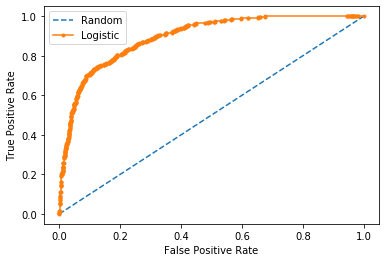

In [15]:
challenger_model(train_table,test_table,False,'Revenue')

## Now we use better model classifiers and do tuning

In [16]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

In [17]:
Train_cols = train_table.columns.tolist()
Train_cols.remove('Revenue')

train_features,train_target = train_table[Train_cols],train_table['Revenue']
test_features,test_target = test_table[Train_cols],test_table['Revenue']

In [18]:
data = lgb.Dataset(train_features.values,train_target.values)

def lgb_cv(n_estimators,feature_fraction,bagging_fraction,min_data_in_leaf,max_depth,min_split_gain,num_leaves,lambda_l1,lambda_l2,num_iterations=1000):
        params = {'objective':'binary','num_iterations': num_iterations, 'early_stopping_round':30, 'metric':'l1'}
        params['n_estimators'] = int(round(n_estimators))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params["min_data_in_leaf"] = int(round(min_data_in_leaf))
        params['max_depth'] = int(round(max_depth))
        params['min_split_gain'] = min_split_gain      
        params["num_leaves"] = int(round(num_leaves))
        params['lambda_l1'] = max(lambda_l1, 0)
        params['lambda_l2'] = max(lambda_l2, 0)
        
        cv_result = lgb.cv(params, data, nfold=5, seed=2, stratified=True, verbose_eval =50)
        return -(min(cv_result['l1-mean']))

lgb_bo = BayesianOptimization(
        lgb_cv,
        {'n_estimators': (10,100),
        'feature_fraction': (0.5, 1),
        'bagging_fraction': (0.5, 1),
        'min_data_in_leaf': (1,100),
        'max_depth': (3, 15),
         'min_split_gain': (0, 5),
         'num_leaves': (8, 128),
         'lambda_l1': (0, 100),
         'lambda_l2': (0, 100)}
    )

lgb_bo.maximize(init_points=21,n_iter=90)
print (lgb_bo.max)

|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | max_depth | min_da... | min_sp... | n_esti... | num_le... |
-------------------------------------------------------------------------------------------------------------------------------------
[50]	cv_agg's l1: 0.164787 + 0.00292351
[100]	cv_agg's l1: 0.16206 + 0.00297088
|  1        | -0.1621   |  0.6101   |  0.911    |  74.97    |  75.38    |  8.278    |  80.12    |  0.315    |  53.04    |  50.59    |
[50]	cv_agg's l1: 0.165316 + 0.00275368
[100]	cv_agg's l1: 0.16055 + 0.00288831
|  2        | -0.1606   |  0.6481   |  0.6872   |  69.21    |  43.57    |  9.055    |  28.13    |  0.2945   |  15.96    |  47.23    |
[50]	cv_agg's l1: 0.16113 + 0.00270023
[100]	cv_agg's l1: 0.151281 + 0.0030109
|  3        | -0.1508   |  0.7108   |  0.5896   |  17.69    |  92.66    |  3.215    |  86.14    |  2.83     |  36.59    |  110.2    |
[50]	cv_agg's l1: 0.151644 + 0.00331731
[100]	cv_agg's l1: 0.148152 + 0.00343222
|  4      

In [19]:
train_features = train_features.reset_index().drop(columns='index')
train_target = train_target.reset_index()['Revenue']

In [20]:
best_params = lgb_bo.max['params']
best_params['num_leaves'] = int(best_params['num_leaves'])
best_params['max_depth'] = int(best_params['max_depth'])
best_params['min_data_in_leaf'] = int(best_params['min_data_in_leaf'])
best_params['n_estimators'] = int(best_params['n_estimators'])

optimized = lgb.LGBMClassifier(**best_params)

In [21]:
#baseline = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100,max_depth=3, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10)
optimized.fit(train_features,train_target)
predictors=list(train_features)

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.929


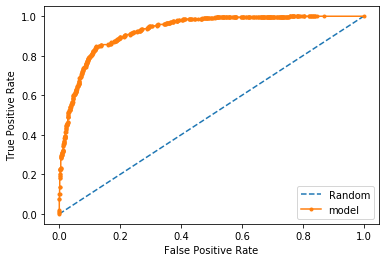

In [23]:
plot_auc(train_table,test_table,'Revenue',optimized)

In [29]:
cols_f = train_features.columns.tolist()
importance = list(optimized.feature_importances_)

res = []
for i,v in enumerate(importance):
    col = cols_f[i]
    res.append([col,v])
    
importance_sorted = sorted(res, key=lambda x: x[1])
cols = [a[0] for a in importance_sorted]
vals = [a[1] for a in importance_sorted]

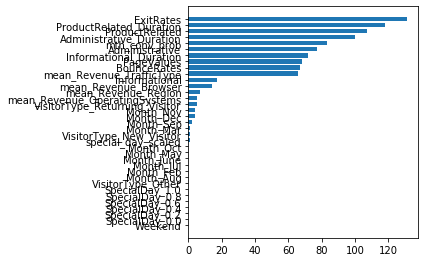

In [40]:
plt.barh(cols, vals, height=0.7)
plt.yticks(cols)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()